# Прогнозирование заказов такси

Компания _«Чётенькое такси»_ собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания. Значение метрики **RMSE** на тестовой выборке* должно быть **не больше 48**.

*тестовая выборка размером 10% от исходных данных.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка данных

In [1]:
# импорт основных библиотек
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from tqdm import tqdm

# импорт спец. библиотек
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 12345

# адреса расположения датасета
home_path = 'datasets/taxi.csv'
server_path = '/datasets/taxi.csv'

### Чтение и знакомство с данными

In [2]:
# домашняя версия
if os.path.exists(home_path):
    df = pd.read_csv(home_path, parse_dates=['datetime'], index_col='datetime')
    print('Файл прочитан.')

# сетевая версия
elif os.path.exists(server_path):
    df = pd.read_csv(server_path, parse_dates=['datetime'], index_col='datetime')
    print('Файл прочитан.')

else:
    print('Не удалось прочесть файл. Возможно, был указан неверный путь.')

Файл прочитан.



---< Исходный датасет >---


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



---< Стат. информация >---


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


-----< Техническая информация >-----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None 
Хронологический порядок соблюден: True



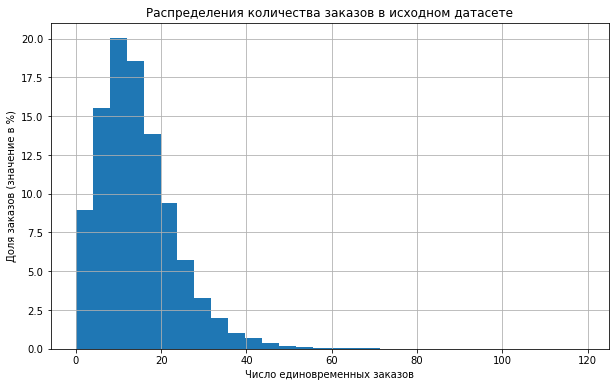

In [3]:
# знакомство с данными
print('\n---< Исходный датасет >---')
display(df.head())

print('\n---< Стат. информация >---')
display(df.describe())

print('-----< Техническая информация >-----')
print(df.info(), f'\nХронологический порядок соблюден: {df.index.is_monotonic}\n')

df['num_orders'].hist(bins=30, figsize=(10, 6), weights=np.ones(len(df)) / len(df) * 100) # density=True - работает не корректно
plt.title('Распределения количества заказов в исходном датасете')
plt.xlabel('Число единовременных заказов')
plt.ylabel('Доля заказов (значение в %)');

**Описание данных:**
- `datetime` - момент фиксации количествава заказов (тип данных: `datetime64`);
- `num_orders` - количество заказов находится в столбце (целочисленный тип данных: `int64`).

Датасет содержит сведенья за 6 месяцев: **март-авргуст 2018** года. Около **26 500 записей** о кол-ве заказов такси, фиксируемых каждый 10 минут. Пропуски в данных и дублирование дат - отсутствуют. Для каждого параметра установлен соответствующий тип данных. В датасете присутствуют выбросы.
___

### Работа с выбросами и ресемплирование

На предыдущем графике легко заметить, что число единовременных заказов доходит до 120, при этом такие случаи - еденичны. Обычно фиксируется не более 42 заказов каждые 10 минут. График распределения этих значений частично описывается _нормальным распределением_. Это помогает определить _границу_. Согласно "Правилу трёх σ" это ранее упомянутое число в 42 заказа, за пределами которого находятся выбрасы около 1% данных.

Возможны три варианта устранение выбросов:
1. Сначала избавить исходные данные от эти объектов, а после выполнить необходимую процедуру ресемплинга, и продолжить работу.

2. Наоборот: Сначала выполнить ресемплинг, поскольку при объединении шести записей в одну происходит апроксимация (устреднение). Завышенные значения могут быть компенсированы заниженными значениями, расположенных по соседству.

3. Поскольку выбросами являются объекты с повышенным числом заказов, то следует избавиться именно от той части заказов, которая "свыше обычной нормы". Заменить выбросы на максимальное значение, в пределах нормального распределения. Ведь, предыдущие вариантам удаляли сведенья о заказах целиком, оставляя пробел в хронологии, что не совсем верно, поскольку "базовый" поток заказав - присутствует.

In [4]:
df_copy = df.copy()

# ресемплирование с выбросами
df_resample_outlier = df_copy.resample('1H').sum()
df_resample_outlier.columns = ['с выбросами']

# выявление и удаление выбросов
display(df_copy[df_copy['num_orders'] > 42])
print(f"Удалено {len(df_copy[df_copy['num_orders'] > 42])} объектов.")
df_copy = df_copy[df_copy['num_orders'] <= 42]

# ресемплирование без выбросов
df_resample = df_copy.resample('1H').sum()
df_resample.columns = ['без выбросов']

,num_orders
datetime,
2018-03-24 00:50:00,56
2018-04-23 00:50:00,45
2018-04-24 00:10:00,49
2018-04-24 00:20:00,58
2018-04-24 00:30:00,68
...,...
2018-08-31 09:40:00,48
2018-08-31 09:50:00,44
2018-08-31 17:50:00,44


Удалено 276 объектов.


,без выбросов,с выбросами
count,4416.000000,4416.000000
mean,81.193388,84.422781
std,38.316938,45.023853
min,0.000000,0.000000
25%,54.000000,54.000000
50%,78.000000,78.000000
75%,106.000000,107.000000
max,220.000000,462.000000


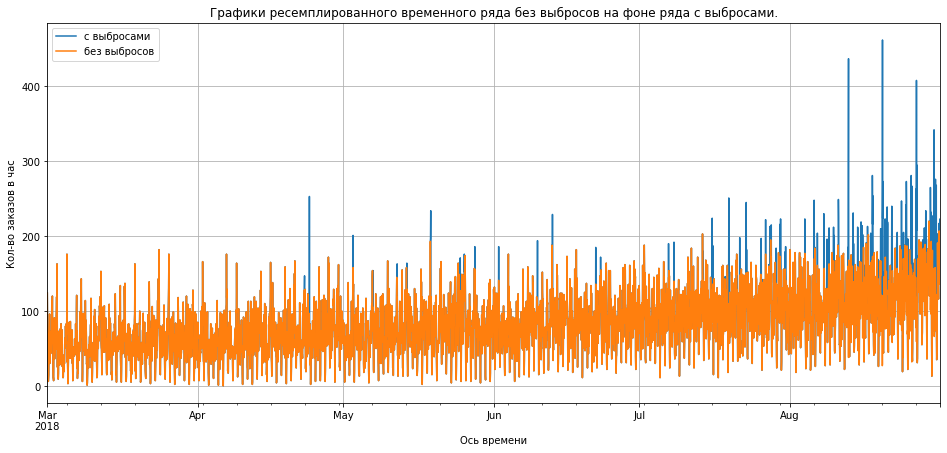

In [5]:
# визуализация результата удаления выбросов
df_resample_outlier['с выбросами'].plot(figsize=(16, 7), legend=True, grid=True)
df_resample['без выбросов'].plot(figsize=(16, 7), legend=True, grid=True)
plt.title('Графики ресемплированного временного ряда без выбросов на фоне ряда с выбросами.')
plt.ylabel('Кол-во заказов в час')
plt.xlabel('Ось времени');

# сравнительная таблица статистических значений
display(df_resample.describe().join(df_resample_outlier.describe()))

In [6]:
# выявление и удаление выбросов из ресемплированного датасета
num_orders_median = df_resample_outlier['с выбросами'].median()
num_orders_sigma  = df_resample_outlier['с выбросами'].std()
num_orders_newmax = num_orders_median + num_orders_sigma*3

outlier_index = df_resample_outlier[df_resample_outlier['с выбросами'] > num_orders_newmax].index
display(df_resample_outlier.loc[outlier_index].head())

df_resample_outlier.drop(outlier_index, inplace=True)
print(f"Удалено {len(outlier_index)} объектов.")

,с выбросами
datetime,
2018-04-24 00:00:00,253
2018-05-19 00:00:00,234
2018-06-13 02:00:00,229
2018-07-16 00:00:00,224
2018-07-19 10:00:00,251


Удалено 59 объектов.


,до ресемплирования,после ресемплирования
count,4416.000000,4357.000000
mean,81.193388,82.156300
std,38.316938,40.460942
min,0.000000,0.000000
25%,54.000000,54.000000
50%,78.000000,78.000000
75%,106.000000,106.000000
max,220.000000,213.000000


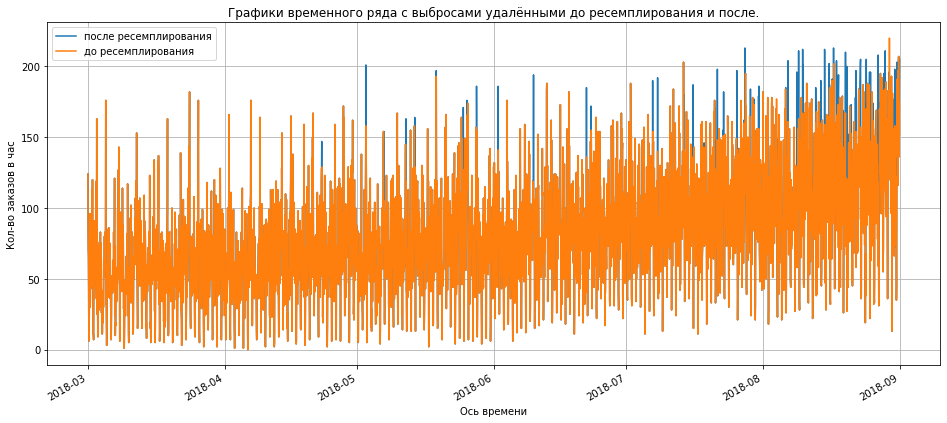

In [7]:
# визуализация временного ряда с удалёнными выбросами на разных этапах
df_resample_outlier.columns = ['после ресемплирования']
df_resample_outlier['после ресемплирования'].plot(figsize=(16, 7), legend=True, grid=True)

df_resample.columns = ['до ресемплирования']
df_resample['до ресемплирования'].plot(figsize=(16, 7), legend=True, grid=True)
plt.title('Графики временного ряда с выбросами удалёнными до ресемплирования и после.')
plt.ylabel('Кол-во заказов в час')
plt.xlabel('Ось времени');

# сравнительная таблица статистических значений
display(df_resample.describe().join(df_resample_outlier.describe()))

Несмотря на то, что временные ряда получилось привести к схожему виду разными путями, между ними есть существенные отличия. Вариант №1 (удаление выбросов до ресемплирования):
- имеет меньшее стандартное отклонение σ,
- распределение более схожее с нормальным, т.к. медианное и среднее значения имеют не большую разницу,
- получившаяся выборка содержит больше объектов, чем при варианте №2.

,num_orders_change_on,num_orders_change_off
count,26496.000000,26496.000000
mean,14.070463,14.070463
std,9.211330,9.211330
min,0.000000,0.000000
25%,8.000000,8.000000
50%,13.000000,13.000000
75%,19.000000,19.000000
max,119.000000,119.000000


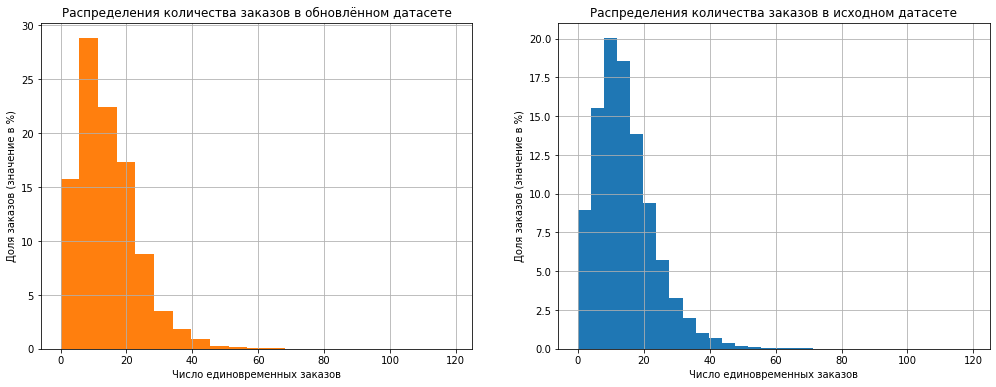

In [8]:
# вариант №3 - замена выбросов на макс. значение

df_change = df.copy()
df_change.loc[df_change['num_orders'] > num_orders_newmax, 'num_orders'] = num_orders_newmax
display(df_change.describe().join(df.describe(), lsuffix='_change_on', rsuffix='_change_off'))

fig, axs = plt.subplots(1, 2, figsize=(17, 6))

axs[0].hist(df_change['num_orders'], bins=21, weights=np.ones(len(df_change)) / len(df_change) * 100, color='#FF7F0E')
axs[0].set_title('Распределения количества заказов в обновлённом датасете')
axs[0].set_ylabel('Доля заказов (значение в %)')
axs[0].set_xlabel('Число единовременных заказов')
axs[0].grid()

axs[1].hist(df['num_orders'], bins=30, weights=np.ones(len(df)) / len(df) * 100)
axs[1].set_title('Распределения количества заказов в исходном датасете')
axs[1].set_ylabel('Доля заказов (значение в %)')
axs[1].set_xlabel('Число единовременных заказов')
axs[1].grid()
plt.show()

,замена,удаление
count,4416.000000,4416.000000
mean,84.422781,81.193388
std,45.023853,38.316938
min,0.000000,0.000000
25%,54.000000,54.000000
50%,78.000000,78.000000
75%,107.000000,106.000000
max,462.000000,220.000000


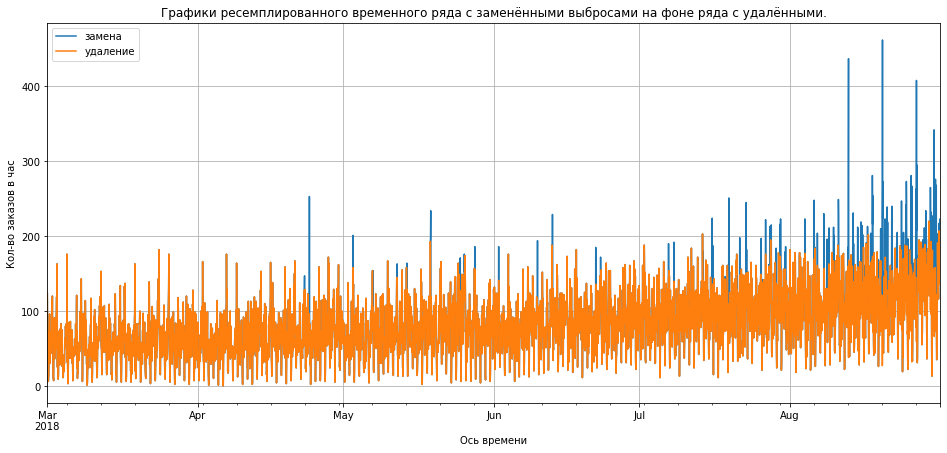

In [9]:
# сравнение методов борьбы с выбросами: удаление и замена
df_change = df_change.resample('1H').sum()
df_change.columns = ['замена']
df_resample.columns = ['удаление']

# сравнительная таблица статистических значений
display(df_change.describe().join(df_resample.describe()))

# визуализация результатов
df_change['замена'].plot(figsize=(16, 7), legend=True, grid=True)
df_resample['удаление'].plot(figsize=(16, 7), legend=True, grid=True)
plt.title('Графики ресемплированного временного ряда с заменёнными выбросами на фоне ряда с удалёнными.')
plt.ylabel('Кол-во заказов в час')
plt.xlabel('Ось времени');

**Итог:** Временные ряды получились практически идентичным, за исключением стандартного отклонения, поскольку у выбросов были отсечены только "верхушни", и эти объекты остались с максимально высокими значениями, что отображает повышенный спрос на такси, но теперь в пределах нормального распределения.

В связи с вышесказанным, **далее**, в работе будет использоваться датасет с удалёнными выбросами до ресемплировании. Ресемплирование выполнено с шагов 1 час (_заданный горизонт прогнозирования_).

In [10]:
# сохранение наилучшего результата
df = df_resample.copy()
df.columns = ['num_orders']

### Анализ данных

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


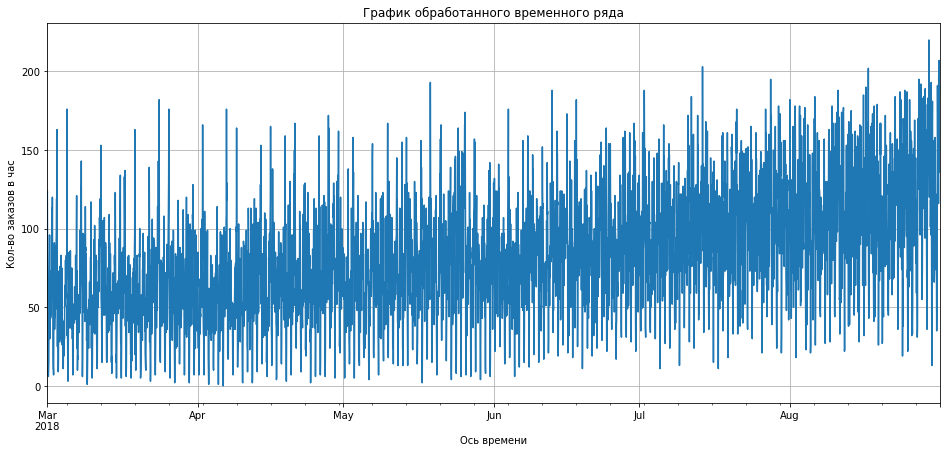

In [11]:
# обновлённый вид данных
display(df.head())
df['num_orders'].plot(figsize=(16, 7), grid=True,
                      title='График обработанного временного ряда',
                      ylabel='Кол-во заказов в час',
                      xlabel='Ось времени');

Временной ряд насыщен объектами. Он не статичен: _среднее число заказов_ и _стандартное отклонение_ - увеличивается. Прослеживается **общая динамика роста** заказов, и должна присутствовать _сезонность_, поскольку в течение дня или недели количество заказов разнится. Далее будет разобран временной ряд отдельно по месяцам.

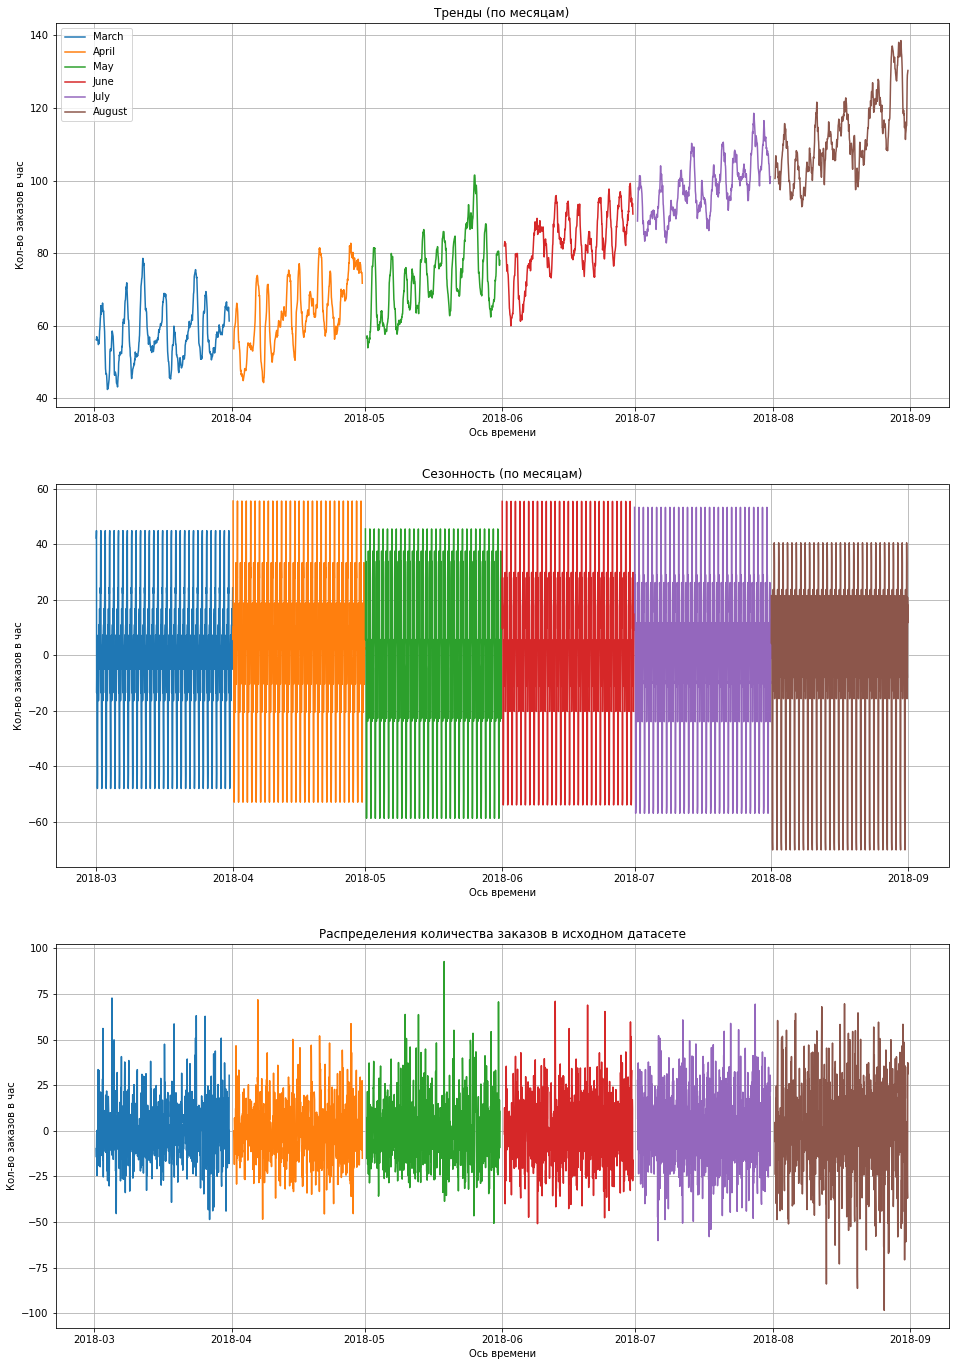

,March,April,May,June,July,August
count,744.000000,720.000000,744.000000,720.000000,744.000000,744.000000
mean,57.408602,63.498611,72.919355,82.625000,97.853495,112.330645
std,29.402525,31.130842,33.052085,31.577019,33.415469,39.480316
min,1.000000,0.000000,2.000000,6.000000,11.000000,13.000000
25%,39.000000,43.000000,53.000000,61.000000,76.000000,86.000000
50%,55.000000,61.000000,71.000000,83.000000,97.500000,114.000000
75%,75.000000,80.000000,92.000000,103.000000,121.000000,141.000000
max,182.000000,176.000000,193.000000,188.000000,203.000000,220.000000


In [12]:
# выделение трендов, сезонностей, шума (по месяцам) и др. статистических значений
month_names = []
describe_table = pd.DataFrame(index=df.describe().index)
fig, axs = plt.subplots(3, 1, figsize=(16, 24))

for month in df.index.month.unique():
    describe_table = describe_table.join(df[df.index.month == month].describe(), rsuffix=month)
    name = df[df.index.month == month].index[0].strftime('%B')
    month_names.append(name)
    decomposed_month = seasonal_decompose(df[df.index.month == month])
    axs[0].plot(decomposed_month.trend.rename(name))
    axs[1].plot(decomposed_month.seasonal.rename(name))
    axs[2].plot(decomposed_month.resid.rename(name))

axs[0].set_title('Тренды (по месяцам)')
axs[0].set_ylabel('Кол-во заказов в час')
axs[0].set_xlabel('Ось времени')
axs[0].legend(month_names)
axs[0].grid()

axs[1].set_title('Сезонность (по месяцам)')
axs[1].set_ylabel('Кол-во заказов в час')
axs[1].set_xlabel('Ось времени')
axs[1].grid()

axs[2].set_title('Распределения количества заказов в исходном датасете')
axs[2].set_ylabel('Кол-во заказов в час')
axs[2].set_xlabel('Ось времени')
axs[2].grid()
plt.show()

describe_table.columns = month_names
display(describe_table)

**Тренды**, помимо пульсаций, имеют прослеживаемую закономерность: к концу месяца число заказов выше, чем в начале этого же месяца. Рост выглядит линейным.

**Сезонность*** имеет одинаковый интервал повторения, но каждый месяц имеет разный "размах" значений, а так же отличаютс средним значением, отклонением и присутствием смещением:
- март, апрель и июль - симметричны;
- май, июнь - смещены в бóльшую сторону;
- авруст - смещён в меньшую сторону.

**Остаточная составляющая*** может продемонтрировать величину нетепичных заказов, которые могут возникать не предсказуемо.

*графики отобращают не абсолютную величину заказов, а только их часть (трендовую, сезонную и остаточную). По этой причине графики могут иметь отрицательные значения. А так же могу быть расположенными симметрично относительно нуля, который на самом деле является средним значением за месяц.

_Примечание:_ Более точная информация собрана в виде таблицы со статистическими значениями, сразу после графиков.

Далее будет произведён разобор на составляющие одного месяца.

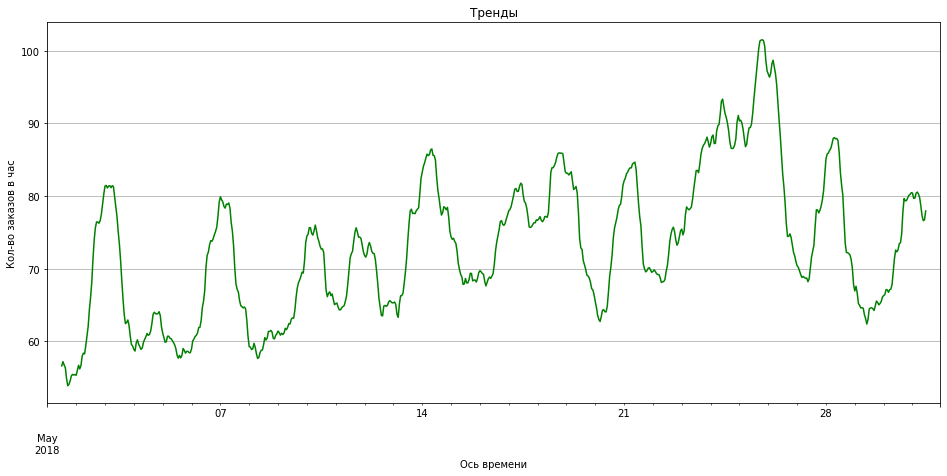

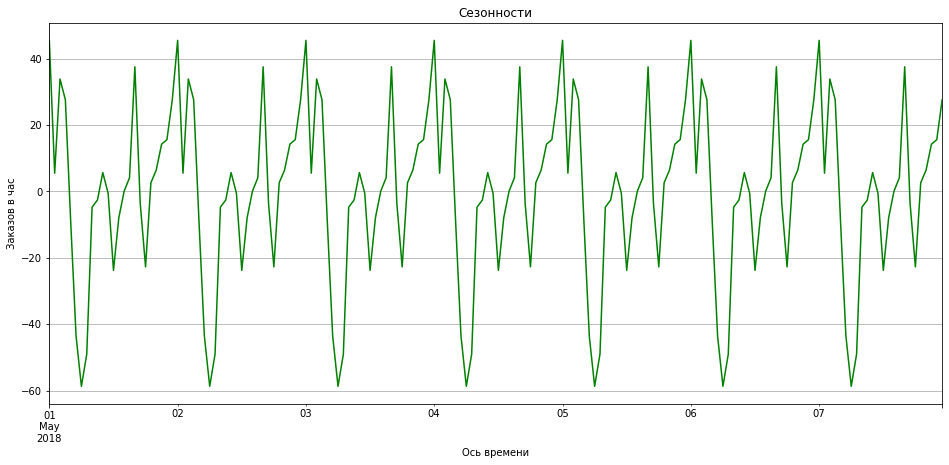

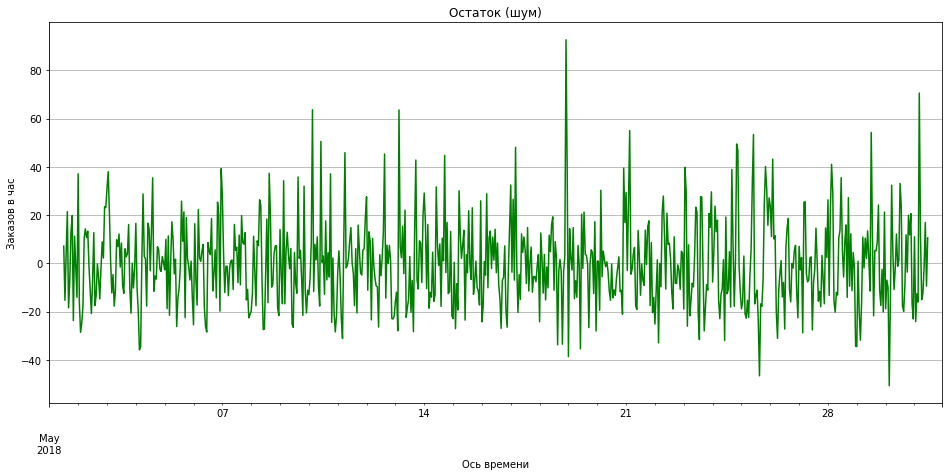

In [13]:
# выделение трендов, сезонностей и шума (МАРТ)
df_month = df[df.index.month == 5]
decomposed_month = seasonal_decompose(df_month)

decomposed_month.trend.plot(figsize=(16,7), grid=True, color='green',
                            title='Тренды', xlabel='Ось времени', ylabel='Кол-во заказов в час')
plt.show()

decomposed_month.seasonal['2018-05-01':'2018-05-07'].plot(figsize=(16,7), grid=True, color='green',
                               title='Сезонности', xlabel='Ось времени', ylabel='Заказов в час')
plt.show()

decomposed_month.resid.plot(figsize=(16,7), grid=True, color='green',
                            title='Остаток (шум)', xlabel='Ось времени', ylabel='Заказов в час')
plt.show()

### Создание признаков

Поскольку в исходных данных присутствует только одна колонка, которой недостачно для точного предсказания, данные будут деконструированы и перезаписаны в отдельные колонки.
- Из _количества заказов_ будут выделены:
    - **отстающие признаки** - это количество заказов за несколько предыдущих часов*;
    - **скользящее среднее** - это среднее количество заказов за несколько ближайщих часов*.
- Из _момента времени_ `2018-06-18 07:00:00` будут выделены **календарные** признаки:
    - месяц (Март - Август);
    - день месяца (1 - 31);
    - день недели (0 - 6 / "Понедельник" - "Воскресенье");
    - час (0 - 23).
    
*количество часов подбирается в зависимости от данных

Ниже описана функция формирующая новые признаки.

In [14]:
# функция создание признаков
def make_features(df, max_lag, window_size):
    
    # отстающие (предыдущие) признаки / lag features
    for lag in range (1, max_lag+1):
        df['num_orders_{}'.format(lag)] = df['num_orders'].shift(periods=lag, fill_value=df.iloc[-1, lag-1])
    
    # скользящее среднее / rolling mean
    df['rolling_mean'] = df['num_orders'].shift().rolling(window_size).mean()
    df['rolling_std']  = df['num_orders'].shift().rolling(window_size).std()
    
    # календарные признаки / calendar features
    df['month']     = df.index.month
    df['dayofweek'] = df.index.dayofweek
    df['day']       = df.index.day
    df['hour']      = df.index.hour
    
    # удаление новообразованных пустых объектов
    df.dropna(inplace=True)

## Обучение моделей

### Валидация данных

Деление исходного датасета на 3 выборки под разные задачи:
- **Тренировочная** (90%) — на её объектах модель будет обучена;
- **Тестовая** (10%) — на её объектах будет произведён итоговый тест для оценки качества модели.

Поскольку выборка относительно небольшая и увеличивать её - означает потеря актуальности, для подбора гиперпараметров моделей будет использована **кросс вылидация**.

In [15]:
# выделение признаков
make_features(df, 3, 3)
display(df.head())
target = df['num_orders']
features = df.drop(['num_orders'], axis=1)

# выделение тренировочной и тестовой выборок
X_train, X_test, Y_train, Y_test = train_test_split(features,
                                                      target,
                                                      train_size=0.9,
                                                      shuffle=False,
                                                      random_state=RANDOM_STATE)

,num_orders,num_orders_1,num_orders_2,num_orders_3,rolling_mean,rolling_std,month,dayofweek,day,hour
datetime,,,,,,,,,,
2018-03-01 03:00:00,66,71,85,124,93.333333,27.465129,3,3,1,3
2018-03-01 04:00:00,43,66,71,85,74.000000,9.848858,3,3,1,4
2018-03-01 05:00:00,6,43,66,71,60.000000,14.933185,3,3,1,5
2018-03-01 06:00:00,12,6,43,66,38.333333,30.270998,3,3,1,6
2018-03-01 07:00:00,15,12,6,43,20.333333,19.857828,3,3,1,7


### Масштабирование данных

Сформированные выборки необходимо подготовить к обучению, посколько в текущем формате модель будет работать не корректно. **Численные данные** необходимо привести к единому масштабу, с помощью  техники `Standard Scaler`. Благодаря этому все признаки будут иметь одинаковую значимость.

In [16]:
# масштабирование признаков
numeric = ['num_orders_1', 'num_orders_2', 'num_orders_3', 'rolling_mean', 'rolling_std']       

scaler = StandardScaler()
scaler.fit(X_train[numeric])
for features in [X_train, X_test]:
    features[numeric] = scaler.transform(features[numeric])

display(X_train.head())

,num_orders_1,num_orders_2,num_orders_3,rolling_mean,rolling_std,month,dayofweek,day,hour
datetime,,,,,,,,,
2018-03-01 03:00:00,-0.169973,0.220232,1.307534,0.555981,0.417413,3,3,1,3
2018-03-01 04:00:00,-0.309314,-0.169927,0.220421,-0.106025,-0.982064,3,3,1,4
2018-03-01 05:00:00,-0.950279,-0.309269,-0.169824,-0.585408,-0.578154,3,3,1,5
2018-03-01 06:00:00,-1.981397,-0.950245,-0.309198,-1.327311,0.640317,3,3,1,6
2018-03-01 07:00:00,-1.814189,-1.981379,-0.950316,-1.943662,-0.186929,3,3,1,7


### Базовая модель (Dummy model)

Это простейшая "модель", которая делает константное или примитивное предсказание. Её роль заключается в том, чтобы получить ориентир для сравнения качества применяемых моделей: их оценка должна быть ниже, чем оценка базовой модели.

In [17]:
# предсказать среднее
pred = np.ones(len(X_test)) * df['num_orders'].mean()
rmse = mean_squared_error(Y_test, pred) ** 0.5 
print('Значение метрики RMSE: {:.1f}'.format(rmse))

Значение метрики RMSE: 54.2


In [18]:
# предсказать предыдущее значение
pred = Y_test.shift(fill_value = Y_train.iloc[-1])
rmse = mean_squared_error(Y_test, pred) ** 0.5 
print('Значение метрики RMSE: {:.1f}'.format(rmse))

Значение метрики RMSE: 43.3


### Модель линейной регресии (LR)

Если можно так выразится, то это достаточно примитивная модель предсказывания, что является её и слабой и сильной стороной. Она проста в настройке, и выделяется высоким быстродействием. Особенно, если данные закодированы с помощью техники _One Hot Encoding_. Но может давать не такой точный результат, по сравнению с более сложными моделями.

In [19]:
%%time
list_iter = []
list_rmse = []
rmse_min = 50

for iteration in range(10, 101, 10):
    model = LinearRegression(n_jobs=iteration)
    list_cvs = cross_val_score(model, X_train, Y_train, scoring='neg_root_mean_squared_error', cv=4)
    rmse = abs(list_cvs.mean())
    if rmse_min >= rmse:
        rmse_min = rmse 
        best_iter = iteration
        best_LR = model
    list_iter.append(iteration)
    list_rmse.append(rmse)

print('Минимальное значение RMSE: {:.1f}, при количестве итераций: {}'.format(rmse_min, best_iter))

Минимальное значение RMSE: 28.6, при количестве итераций: 100
Wall time: 432 ms


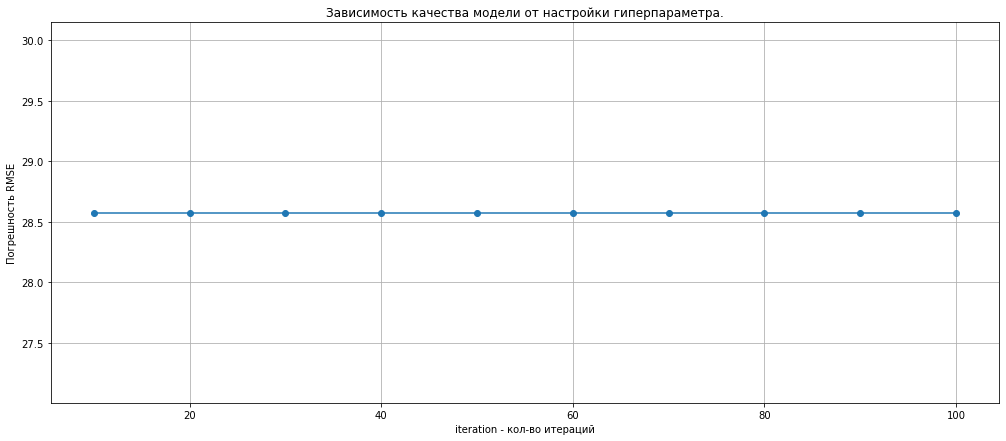

In [20]:
# Визуализация зависимости качества модели от изменения гиперпараметра
rmse_score_data = pd.DataFrame({'iter': list_iter, 'rmse': list_rmse})
rmse_score_data.plot(style='o-', x='iter', y='rmse', grid=True, legend=False, figsize=(17,7),# ylim=[33.275, 33.3],
                     title='Зависимость качества модели от настройки гиперпараметра.',
                     xlabel='iteration - кол-во итераций',
                     ylabel='Погрешность RMSE')
plt.show();

### Модель случайного леса (RF)

Ансамбль (набор) моделей решающих деревьев. Преимущество заключается в том, что вместе модели ошибаются в среднем не так сильно как по отдельности. Из ключевых параметров _Случайного леса_: количество деревьев и их глубина.

In [21]:
list_est = []
list_rmse = []
rmse_min = 50

for est in tqdm(range(10, 51, 10)):
    for depth in range(1, 16):
        model = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
        list_cvs = cross_val_score(model, X_train, Y_train, scoring='neg_root_mean_squared_error', cv=4)
        rmse = abs(list_cvs.mean())
        if rmse_min >= rmse:
            rmse_min = rmse 
            best_dep = depth
            best_est = est
            best_RF  = model
    list_est.append(est)
    list_rmse.append(rmse_min)

print('Минимальное значение RMSE: {:.1f}, при кол-ве деревьев: {}, и их глубине: {}'.format(rmse_min, best_est, best_dep))

100%|████████████████████████████████████████████| 5/5 [01:38<00:00, 19.73s/it]

Минимальное значение RMSE: 24.6, при кол-ве деревьев: 50, и их глубине: 13


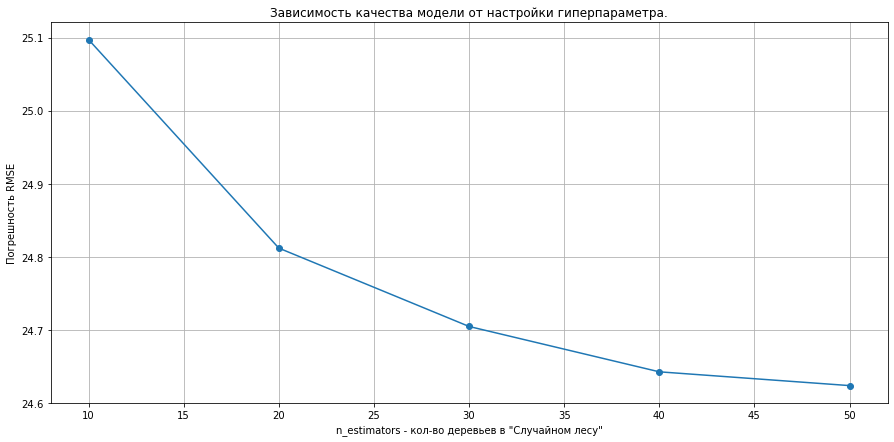

In [22]:
# Визуализация зависимости качества модели от изменения гиперпараметра
rmse_score_data = pd.DataFrame({'est': list_est, 'rmse': list_rmse})
rmse_score_data.plot(style='o-', x='est', y='rmse', grid=True, legend=False, figsize=(15,7),
                     title='Зависимость качества модели от настройки гиперпараметра.',
                     xlabel='n_estimators - кол-во деревьев в "Случайном лесу"',
                     ylabel='Погрешность RMSE')
plt.show();

### Модель гриентного бустинга LightGBM

Последовательно построенный ансамблю моделей, каждая из которых учитывает ошибку предыдущей, и уменьшает её.

In [23]:
list_est = []
list_rmse = []
rmse_min = 50

for est in tqdm(range(10, 161, 10)):
    for depth in range(1, 6):
        model = lgb.LGBMRegressor(max_depth=depth, n_estimators=est, random_state=RANDOM_STATE)
        list_cvs = cross_val_score(model, X_train, Y_train, scoring='neg_root_mean_squared_error', cv=4)
        rmse = abs(list_cvs.mean())
        if rmse_min >= rmse:
            rmse_min = rmse 
            best_dep = depth
            best_est = est
            best_GBM = model
    list_est.append(est)
    list_rmse.append(rmse_min)

print('Минимальное значение RMSE: {:.1f}, при кол-ве баз. деревьев: {}, и их глубине: {}'.format(rmse_min, best_est, best_dep))

100%|██████████████████████████████████████████| 16/16 [00:23<00:00,  1.50s/it]

Минимальное значение RMSE: 23.0, при кол-ве баз. деревьев: 130, и их глубине: 5


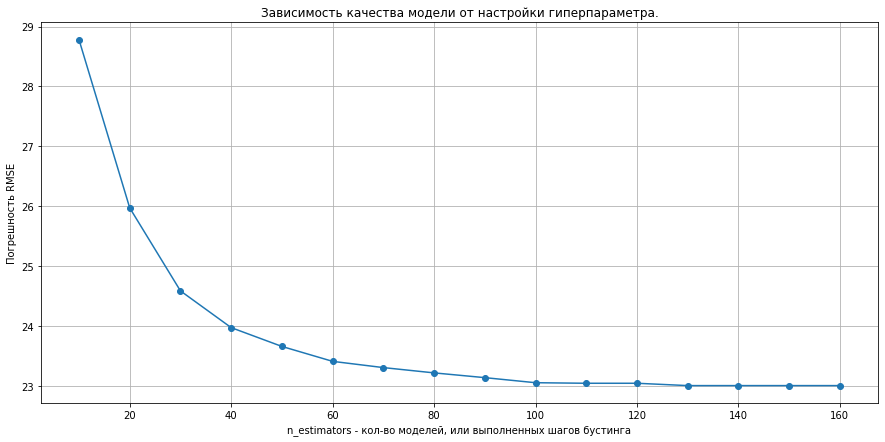

In [24]:
# Визуализация зависимости качества модели от изменения гиперпараметра
rmse_score_data = pd.DataFrame({'est': list_est, 'rmse': list_rmse})
rmse_score_data.plot(style='o-', x='est', y='rmse', grid=True, legend=False, figsize=(15,7),
                     title='Зависимость качества модели от настройки гиперпараметра.',
                     xlabel='n_estimators - кол-во моделей, или выполненных шагов бустинга',
                     ylabel='Погрешность RMSE')
plt.show();

## Тестирование моделей

In [25]:
# ЛИНЕЙНАЯ РЕГРЕССИЯ

model = best_LR
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction))
print('Значение RMSE: {:.1f}'.format(rmse))
t = %timeit -n10 -r10 -o model.fit(X_train, Y_train)
t = %timeit -n10 -r10 -o prediction = model.predict(X_test)

Значение RMSE: 36.4
4 ms ± 289 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
2.35 ms ± 241 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [26]:
# СЛУЧАЙНЫЙ ЛЕС

model = best_RF
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction))
print('Значение RMSE: {:.1f}'.format(rmse))
t = %timeit -n10 -r10 -o model.fit(X_train, Y_train)
t = %timeit -n10 -r10 -o prediction = model.predict(X_test)

Значение RMSE: 35.5
1.03 s ± 3.29 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
13.4 ms ± 256 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [27]:
# ГРАДИЕНТНЫЙ БУСТИНГ

model = best_GBM
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, prediction))
print('Значение RMSE: {:.1f}'.format(rmse))
t = %timeit -n10 -r10 -o model.fit(X_train, Y_train)
t = %timeit -n10 -r10 -o prediction = model.predict(X_test)

Значение RMSE: 34.4
149 ms ± 11.6 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
5.27 ms ± 628 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


**ИТОГ:** Общее время работы моделей крайне мало, чтобы это могло иметь большое значение. Тем более в условиях поставленной задачи, где отсутствует об этом упоминание. Тем не менее я указжу это время в качестве справочной информации.
- **Линейная регрессия** - самая быстродейственная модель: обучение 4.5 мс., предсказания ~3 мс. Самое большое значение метрики: **36.4**.
- **Случайный лес** - самая медлительная модель: обучение 1 секунда, предсказания 15 мс. Значение RMSE: **35.5**.
- **Градиентный бустинг** - золотая середина: обучение 160 мс., предсказания ~7 мс. RMSE: **34.4**, что соизмеримо с результатами предыдущих моделей, но решающим значением является меньшее время. По этим причинам я рекомендую эту модель.


*время обучения и предсказания могут отличаться в зависимости от устройства (ПК/сервера) на которо выполняются эти операции.

_Примечание_: Исходя из небольшого времени, требуемого для пердсказания есть возможность снизить погрешность - уменьшив временной интервал, вернуться к исходному шагу в 10 минут. Данные, используемые в этом проекте, подойдут для этой задачи.
___

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48